# FDM simulation cost (pseudo-spectral method)

In [27]:
import astropy.cosmology as cosmo
import astropy.units as units
import numba
import numpy
import matplotlib
import matplotlib.pyplot as plt
import pandas

%matplotlib notebook

BOX_SIZE = 1000
FFTW_COMPLEX_SIZE = 16 # bytes
FFTW_REAL_SIZE = FFTW_COMPLEX_SIZE // 2 # bytes
TIMEBASE = 1 << 29

UnitLength_in_cm         = 3.085678e21 # 1.0 kpc
UnitMass_in_g            = 1.989e43    # 1.0e10 solar masses
UnitVelocity_in_cm_per_s = 1e5         # 1.0 km/s
UnitTime_in_s = UnitLength_in_cm / UnitVelocity_in_cm_per_s
EV_TO_G = 1.78266191e-33
HBAR = 1.0545718e-27 / UnitLength_in_cm**2 / UnitMass_in_g * UnitTime_in_s

C = cosmo.FlatLambdaCDM(H0=70, Om0=0.3)
Om0 = C.Om0
Ode0 = C.Ode0
H0 = C.H0.to(1 / (UnitTime_in_s * units.s)).to_value()
h = C.h

## Memory
- Freya: 104 nodes with 192GB per node (4 × 384GB), 40 cores per node
- Cobra: islands with 636 nodes, 96GB or 192 GB per node (8 × 768 GB), 40 cores per node

In [28]:
PMGRID = 2**14
GB = 1024**3
GRID_MEMORY = PMGRID**3 * (FFTW_COMPLEX_SIZE + FFTW_REAL_SIZE) / GB
EXTRA_MEMORY = 100 # GB
TOTAL_MEMORY = GRID_MEMORY + EXTRA_MEMORY
NODE_MEMORY = 192 # GB

print(f'PMGRID = {PMGRID}')
print(f'Required memory: {TOTAL_MEMORY} GB')
print(f'=> {TOTAL_MEMORY / NODE_MEMORY:g} nodes with {NODE_MEMORY} GB')

PMGRID = 16384
Required memory: 98404.0 GB
=> 512.521 nodes with 192 GB


## Time step
$\begin{align}
i\hbar \frac{\partial \psi}{\partial t} &= -\frac{\hbar^2}{2ma^2} \nabla^2 \psi + m V \psi
\\
\nabla^2 V &= \frac{4\pi G}{a} (|\psi^2| - \bar{\rho})
\end{align}$

$\begin{align}
\Delta t \le \max\!\left(a^2 \frac{m}{6\hbar} \Delta x^2, a \frac{\hbar}{m |V_{\text{max}}|}\right)
\end{align}$
(arXiv:1606.05151, arXiv:1705.05845)

In [ ]:
def time_step_qty(cell_len, mass, a):
    m = mass * EV_TO_G / UnitMass_in_g
    return units.Quantity(a**2 * m / (6 * HBAR) * cell_len**2, UnitTime_in_s * units.s)

@numba.njit
def time_step(cell_len, mass, a):
    m = mass * EV_TO_G / UnitMass_in_g
    return a**2 * m / (6 * HBAR) * cell_len**2

@numba.njit
def get_time_step_binned(dt, Timebase_interval):
    dt = int(dt / Timebase_interval)
    bin = -1
    while dt:
        bin += 1
        dt >>= 1
    dt = (1 << bin) * Timebase_interval
    return dt

@numba.njit
def get_Timebase_interval(a_start, a_end):
    return (numpy.log(a_end) - numpy.log(a_start)) / TIMEBASE

@numba.njit
def get_hubble(a):
    hubble_a = Om0 / (a * a * a) + (1 - Om0 - Ode0) / (a * a) + Ode0
    hubble_a = H0 / h * numpy.sqrt(hubble_a)
    return hubble_a

@numba.njit
def num_time_steps(cell_len, mass, a_start, a_end, progress=-1):
    Timebase_interval = get_Timebase_interval(a_start, a_end)
    a = a_start
    ti = 0
    steps = 0
    while a < a_end:
        hubble_a = get_hubble(a)
        dt = hubble_a * time_step(cell_len, mass, a)
        ti += get_time_step_binned(dt, Timebase_interval)
        a = a_start * numpy.exp(ti)
        steps += 1
        if progress > 0 and steps % progress == 0: print(steps)
    return steps

def time_step_at(a, cell_len, mass, a_start, a_end):
    Timebase_interval = get_Timebase_interval(a_start, a_end)
    dt_max = time_step(cell_len, mass, a)
    hubble_a = get_hubble(a)
    dt = hubble_a * dt_max
    dt_bin = get_time_step_binned(dt, Timebase_interval)
    da = a * (numpy.exp(dt_bin) - 1)
    print(f'a      = {a}')
    print(f'dt_max = {dt_max}')
    print(f'dt     = {dt}')
    print(f'dt_bin = {dt_bin}')
    print(f'da     = {da}')

num_time_steps(1000 / 256, 1e-22, C.scale_factor(127), 2)
num_time_steps(1000 / 1024, 1e-22, C.scale_factor(127), 1)

## Duration of a single time step

In [7]:
import itertools
import cpu
idx = pandas.IndexSlice
CORES = [64, 128]
PMGRID_VALUES = [128, 256, 512, 1024]
MASS_VALUES = [1e-24, 1e-23, 1e-22, 1e-21]

step_duration = {'pmgrid': [], 'mass': [], 'cores': [], 'duration': [], 'std': []}
for cores, pmgrid, mass in itertools.product(CORES, PMGRID_VALUES, MASS_VALUES):
    if pmgrid > 512 and cores < 128: continue
    c = cpu.parse_cpu_txt(f'/u/smay/runs/fdm_cpu_time_p{pmgrid}_m{mass}_c{cores}/output/cpu.txt')
    total = c.loc[:, idx[:, ['total', 'i/o']]]
    diff_abs = (total['diff_abs', 'total'] - total['diff_abs', 'i/o']) * cores
    # save data for current parameter point
    step_duration['pmgrid'].append(pmgrid)
    step_duration['mass'].append(mass)
    step_duration['cores'].append(cores)
    step_duration['duration'].append(diff_abs.mean())
    step_duration['std'].append(diff_abs.std())
#     print(
#         f'{cores: 4}', f'{diff_abs.mean(): 9.1f}', '±', f'{diff_abs.std(): 7.1f}'
#     )
step_duration = pandas.DataFrame(step_duration)
step_duration

/afs/ipp/.cs/anaconda/amd64_generic/3/5.3.0/lib/python3.7/site-packages/numpy/lib/arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
/afs/ipp/.cs/anaconda/amd64_generic/3/5.3.0/lib/python3.7/site-packages/numpy/lib/arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
/afs/ipp/.cs/anaconda/amd64_generic/3/5.3.0/lib/python3.7/site-packages/numpy/lib/arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
/afs/ipp/.cs/anaconda/amd64_generic/3/5.3.0/lib/python3.7/site-packages/numpy/lib/arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


pmgrid          mass  cores    duration         std
0      128  1.000000e-24     64    1.871505    0.848402
1      128  1.000000e-23     64    1.939484    2.378295
2      128  1.000000e-22     64    2.622703    8.469615
3      128  1.000000e-21     64    2.726848    9.583447
4      256  1.000000e-24     64    9.543137    0.623532
5      256  1.000000e-23     64    9.612572    4.421213
6      256  1.000000e-22     64   10.133785   14.326271
7      256  1.000000e-21     64   11.985681   30.527075
8      512  1.000000e-24     64   78.943468    7.759989
9      512  1.000000e-23     64   78.991738    7.746465
10     512  1.000000e-22     64   80.089898   30.812673
11     512  1.000000e-21     64   85.139961   93.319706
12     128  1.000000e-24    128    3.867968    3.108443
13     128  1.000000e-23    128    4.186529   10.278348
14     128  1.000000e-22    128    6.715676   35.115584
15     128  1.000000e-21    128    7.167004   38.773824
16     256  1.000000e-24    128   13.030423    1.373857
17     256  1.000000e-23    128   13.254769   11.100631
18     256  1.000000e-22    128   14.094090   34.195590
19     256  1.000000e-21    128   19.633307   88.024126
20     512  1.000000e-24    128   89.180775    8.258554
21     512  1.000000e-23    128   91.303541    8.793588
22     512  1.000000e-22    128   87.872271   65.740164
23     512  1.000000e-21    128  102.736842  197.612368
24    1024  1.000000e-24    128  727.711411  139.835833
25    1024  1.000000e-23    128  729.132399  139.837794
26    1024  1.000000e-22    128  722.494519  138.009980
27    1024  1.000000e-21    128  726.820392  139.557035

In [8]:
# fdm_1mpc_m=5e-23_512, 2 nodes, 32 cores per node, ran in 21:51h (z=127 to a=2)
B_PMGRID = 512
B_BOX_SIZE = 1000 # kpc
B_MASS = 5e-23 # eV
B_CORES = 64
B_Z_START = 127
B_Z_END = 0
B_TIME = 21 * 60 + 51 # minutes

def runtime(hours, minutes, seconds):
    return hours * 60**2 + minutes * 60 + seconds

# pmgrid, mass, num_cores, time
CPU_TIME_DATA = numpy.array([
    [512, 1e-21, 160, runtime(0,  7, 57)],
    [512, 1e-21, 120, runtime(0,  9, 35)],
    [512, 1e-21,  80, runtime(0, 11,  4)],
    [512, 1e-21,  40, runtime(0, 16, 46)],
    [512, 1e-22, 160, runtime(1,  2, 55)],
    [512, 1e-22, 120, runtime(1, 23, 43)],
    [512, 1e-22,  80, runtime(1, 34, 41)],
    [512, 1e-22,  40, runtime(2, 24, 39)],
    [256, 1e-22, 160, runtime(0,  2, 39)],
    [256, 1e-22, 120, runtime(0,  3, 11)],
    [256, 1e-22,  80, runtime(0,  3, 22)],
    [256, 1e-22,  40, runtime(0,  4, 40)],
    [256, 1e-23, 160, runtime(0, 30, 21)],
    [256, 1e-23, 120, runtime(0, 35,  5)],
    [256, 1e-23,  80, runtime(0, 39, 53)],
    [256, 1e-23,  40, runtime(0, 54, 11)],
    [128, 1e-22, 160, runtime(0,  0, 28)],
    [128, 1e-22, 120, runtime(0,  0, 23)],
    [128, 1e-22,  80, runtime(0,  0, 18)],
    [128, 1e-22,  40, runtime(0,  0, 13)],
    [128, 1e-23, 160, runtime(0,  3,  2)],
    [128, 1e-23, 120, runtime(0,  2, 52)],
    [128, 1e-23,  80, runtime(0,  2, 16)],
    [128, 1e-23,  40, runtime(0,  1, 55)],
    [128, 1e-24, 160, runtime(0, 24, 41)],
    [128, 1e-24, 120, runtime(0, 22, 45)],
    [128, 1e-24,  80, runtime(0, 19, 32)],
    [128, 1e-24,  40, runtime(0, 17, 22)],
])

## Velocity criterion
$\begin{align}
\vec{v} &= \frac{\hbar}{m} \nabla \alpha
\quad \left(\psi = \sqrt{\rho} e^{i \alpha}\right)
\\
\Rightarrow v &< \frac{\hbar}{m} \frac{\pi}{\Delta x}
\quad \text{(arXiv:1801.03507)}
\end{align}$

In [42]:
def v_max(cell_len, mass):
    m = mass * EV_TO_G / UnitMass_in_g
    return (HBAR / m) * numpy.pi / cell_len

# for BoxSize = 1 Mpc: v_max ≈ 150 km/s at z = 0
v_max(BOX_SIZE / PMGRID, 1e-22)

986.7937192478503

## Starting redshift

## Open questions
- Running on $2^n$ cores: 32 or 40 cores per node? (E.g. for $2^{13} = 8192$: choose $256 \cdot 32$ or $205 \cdot 40$?)
  - Interestingly, `PMGRID` = $2^{14}$ is the point where memory (> 512 nodes) becomes the deciding factor in the number of nodes as opposed to the maximum number of useful cores ($512 \cdot 32$ or $410 \cdot 40$).
- RAM: Use single precision or double precision for wave function/FFT grid?
- Relevance of the second part of the time step criterion ($V_{\text{max}}$)?
- Best way to get $v_{\text{max}}$ for $\Lambda$CDM boxes (without doing the simulation?)?
  - How does the mass resolution affect velocities?
- How precisely must the $v_{\text{max}}$ criterion be followed (e.g. arXiv:1705.05845 fig. 7 would violate it by a factor of 6 at $z = 0$)?
- Consistency of mean density vs. `astropy.cosmology.FlatLambdaCDM(H0=70, Om0=0.3).critical_density0.to(1e10 * u.solMass / u.kpc**3)`?

---

## Plots

<IPython.core.display.Javascript object>


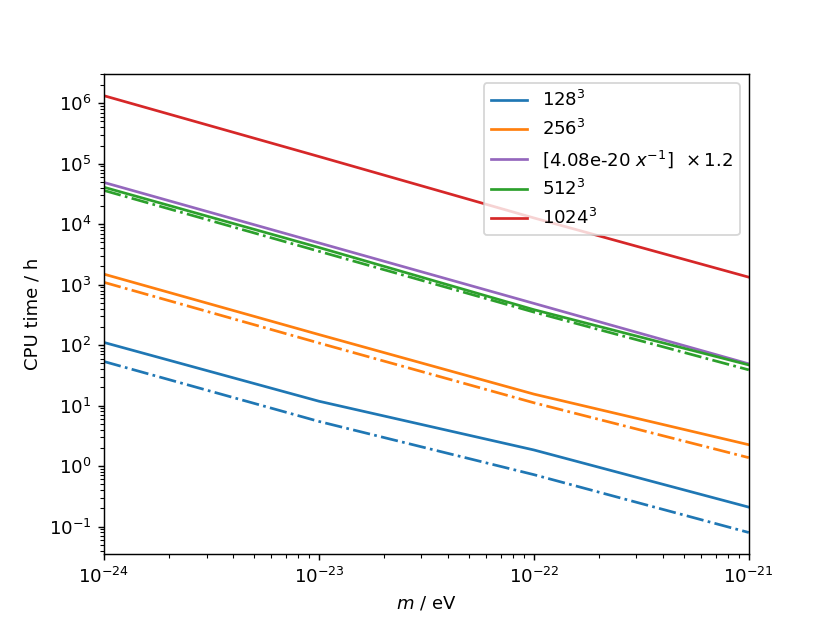

In [33]:
plt.figure()
plt.xlabel('$m$ / eV')
plt.ylabel('CPU time / h')
plt.xscale('log')
plt.yscale('log')
plt.xlim(MASS_VALUES[0], MASS_VALUES[-1])

def fit_func(x, a): return a * x**-1

styles = ['-', '-.']
for style_idx, cores in enumerate(reversed(CORES)):
    style = styles[style_idx]
    d_cores = step_duration[step_duration['cores'] == cores]
    for color, pmgrid in enumerate(PMGRID_VALUES):
        d = d_cores[d_cores['pmgrid'] == pmgrid]
        num_steps = numpy.array([
            num_time_steps(1000 / pmgrid, mass, C.scale_factor(127), 1)
            for mass in d.mass
        ])
        X = d.mass
        Y = d.duration * num_steps / 60**2
        if style_idx == 0 and pmgrid == 512:
            [a,], _ = scipy.optimize.curve_fit(fit_func, X, Y)
            X_fit = numpy.linspace(X.iloc[0], X.iloc[-1], 100)
            Y_fit = fit_func(X_fit, a) * 1.2
            plt.plot(X_fit, Y_fit, f'C{len(PMGRID_VALUES)}', label=f'[{a:.3g} $x^{{-1}}$] $\, \\times 1.2$')
        plot_opt = {}
        if style_idx == 0:
            plot_opt['label'] = f'${pmgrid}^3$'
        else:
            plot_opt['label'] = ''
        plt.plot(X, Y, f'C{color}{style}', **plot_opt)
plt.legend();
plt.savefig('mass.pdf')

<IPython.core.display.Javascript object>


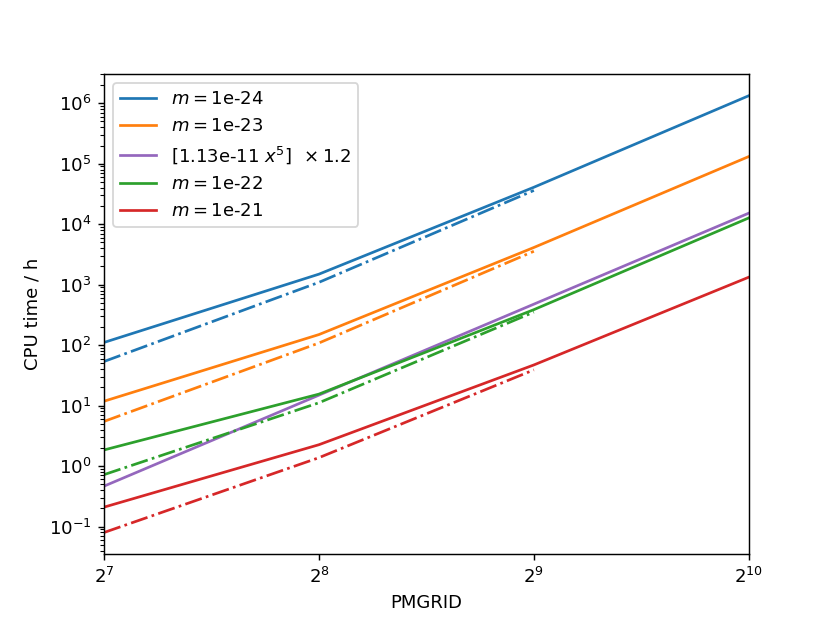

In [32]:
plt.figure()
plt.xlabel('PMGRID')
plt.ylabel('CPU time / h')
plt.xscale('log', basex=2)
plt.yscale('log')
plt.xlim(PMGRID_VALUES[0], PMGRID_VALUES[-1])

def fit_func(x, a): return a * x**5

styles = ['-', '-.']
for style_idx, cores in enumerate(reversed(CORES)):
    style = styles[style_idx]
    d_cores = step_duration[step_duration['cores'] == cores]
    for color, mass in enumerate(MASS_VALUES):
        d = d_cores[d_cores['mass'] == mass]
        num_steps = numpy.array([
            num_time_steps(1000 / pmgrid, mass, C.scale_factor(127), 1)
            for pmgrid in d.pmgrid
        ])
        X = d.pmgrid
        Y = d.duration * num_steps / 60**2
        if style_idx == 0 and mass == 1e-22:
            [a,], _ = scipy.optimize.curve_fit(fit_func, X, Y)
            X_fit = numpy.linspace(X.iloc[0], X.iloc[-1], 100)
            Y_fit = fit_func(X_fit, a) * 1.2
            plt.plot(X_fit, Y_fit, f'C{len(MASS_VALUES)}', label=f'[{a:.3g} $x^5$] $\, \\times 1.2$')
        plot_opt = {}
        if style_idx == 0:
            plot_opt['label'] = f'$m = ${mass}'
        else:
            plot_opt['label'] = ''
        plt.plot(X, Y, f'C{color}{style}', **plot_opt)
plt.legend();
plt.savefig('pmgrid.pdf')